# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

Fixes implemented from here: https://github.com/pradhanhitesh/LayoutParser-Install

In [1]:
import layoutparser as lp
import cv2

## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [2]:
image = cv2.imread("data/paper-image.jpg")
image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [3]:
#model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3xconfig',
#                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})

#model = lp.models.detectron2.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
#                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
#                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

In [4]:
from layoutparser.models.detectron2 import catalog
import copy
import os
import requests as requests

def load_model(
        config_path: str = 'lp://<dataset_name>/<model_name>/config',
):

    config_path_split = config_path.split('/')
    dataset_name = config_path_split[-3]
    model_name = config_path_split[-2]

    # get the URLs from the MODEL_CATALOG and the CONFIG_CATALOG 
    # (global variables .../layoutparser/models/detectron2/catalog.py)
    model_url = catalog.MODEL_CATALOG[dataset_name][model_name]
    config_url = catalog.CONFIG_CATALOG[dataset_name][model_name]

    # override folder destination:
    if 'model' not in os.listdir():
        os.mkdir('model')

    config_file_path, model_file_path = None, None

    for url in [model_url, config_url]:
        filename = url.split('/')[-1].split('?')[0]
        save_to_path = f"model/" + filename
        if 'config' in filename:
            config_file_path = copy.deepcopy(save_to_path)
        if 'model_final' in filename:
            model_file_path = copy.deepcopy(save_to_path)

        # skip if file exist in path
        if filename in os.listdir("model"):
            continue
        # Download file from URL
        r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

        with open(save_to_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=4096):
                if chunk:
                    f.write(chunk)


    return lp.models.Detectron2LayoutModel(
        config_path=config_file_path,
        model_path=model_file_path,
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
        label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
    )

# Load the model
model = load_model('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config')
#layout = model.detect(image)

/Users/ektva999/miniconda3/envs/llm_course/lib/python3.8/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, ma

In [5]:
layout = model.detect(image)
    # Detect the layout of the input image

/Users/ektva999/miniconda3/envs/llm_course/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


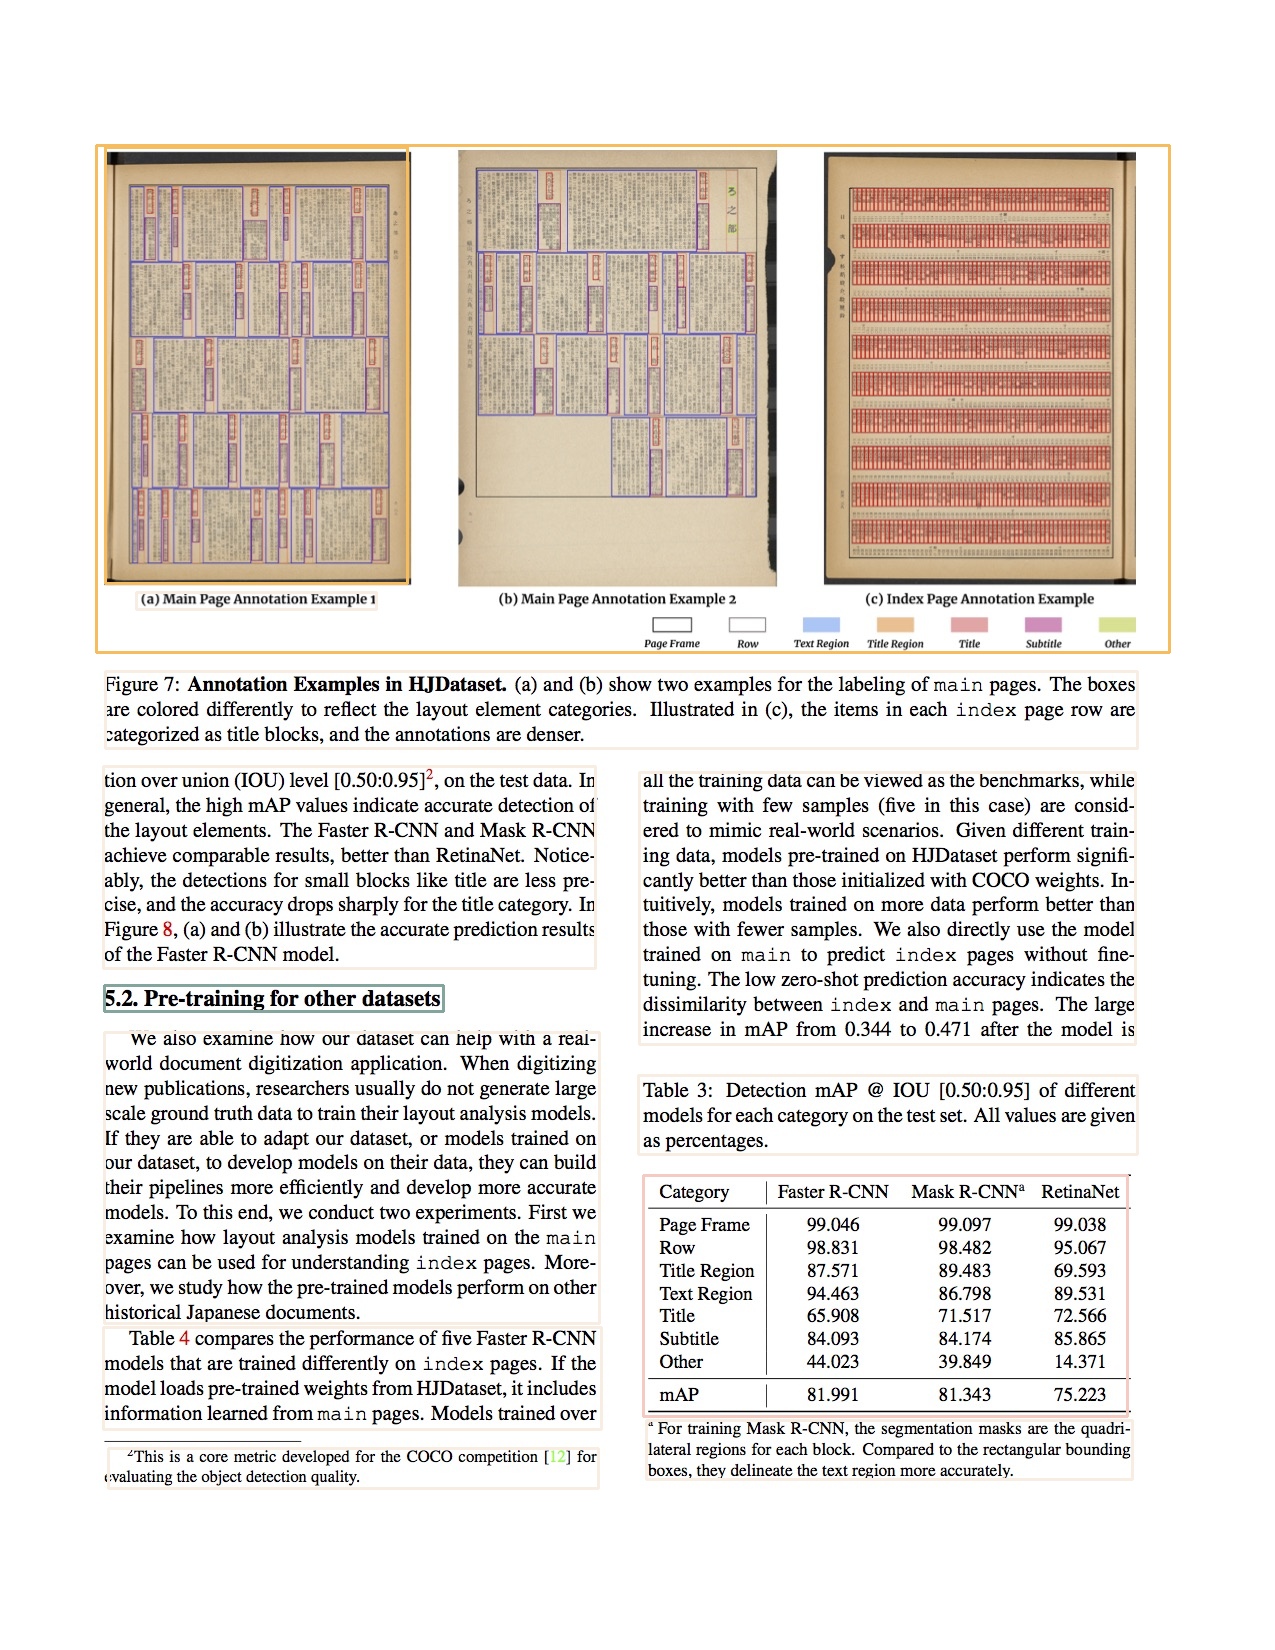

In [6]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

## Check the results from the model 

In [7]:
type(layout)         

layoutparser.elements.layout.Layout

The `layout` variable is a `Layout` instance, which is inherited from list and supports handy methods for layout processing.

In [8]:
layout[0]

TextBlock(block=Rectangle(x_1=646.4181518554688, y_1=1420.1715087890625, x_2=1132.86865234375, y_2=1479.7222900390625), text=None, id=None, type=Text, parent=None, next=None, score=0.9996440410614014)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text regions of specific type:

In [9]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As you will see below, the text recognized as section 5.2 will be dropped
from our layout-recognized text regions as it is parsed as a TextBlock of
type 'Title' as indicated by its different colored bounding box in the image
above.

As there could be text regions detected inside the figure region, we just drop them:

In [10]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally, sort the text regions and assign ids:

In [11]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
#right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
right_blocks=sorted(right_blocks,key = lambda b:b.coordinates[1])

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

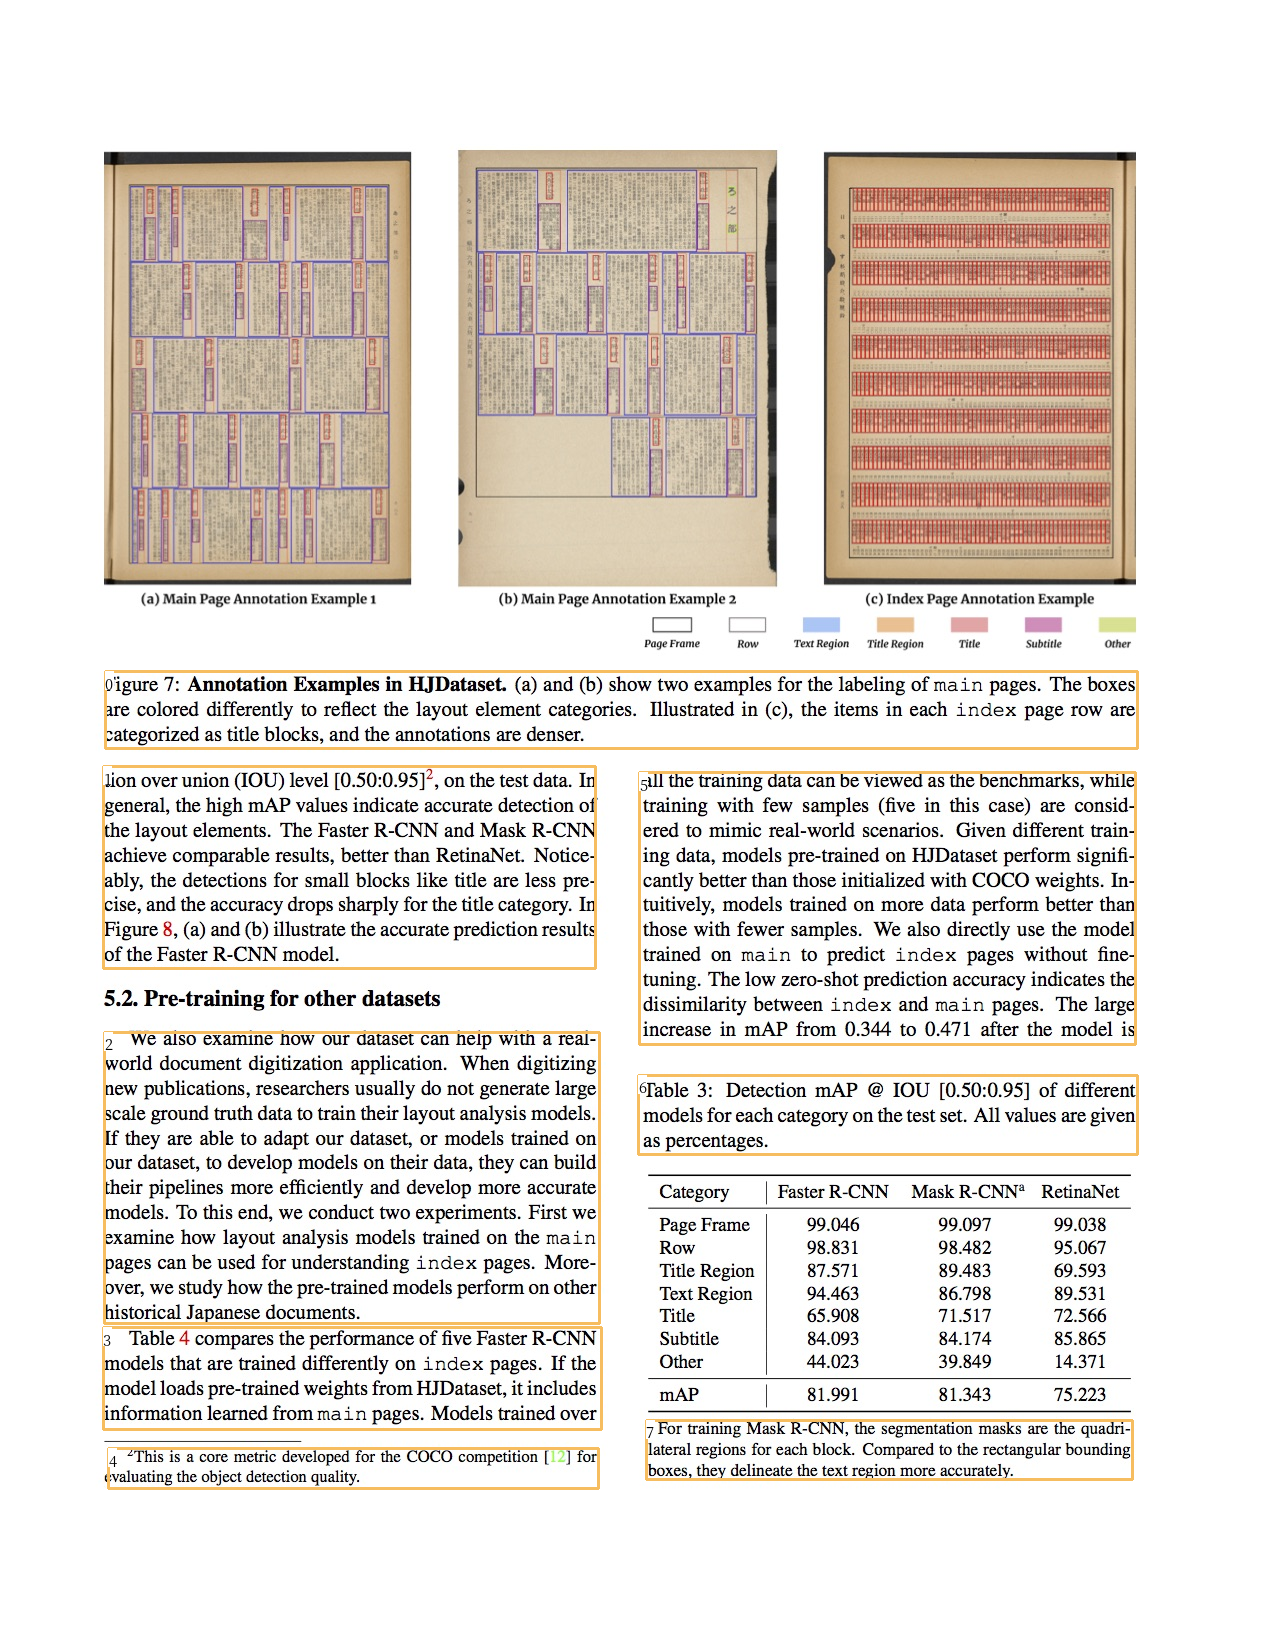

In [12]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [13]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [14]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [15]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Figure 7: Annotation Examples in HJDataset. (a) and (b) show two examples for the labeling of main pages. The boxes
are colored differently to reflect the layout element categories. Illustrated in (c), the items in each index page row are
categorized as title blocks, and the annotations are denser.

---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP values indicate accurate detection of
the layout elements. The Faster R-CNN and Mask R-CNN
achieve comparable results, better than RetinaNet. Notice-
ably, the detections for small blocks like title are less pre-
cise, and the accuracy drops sharply for the title category. In
Figure 8, (a) and (b) illustrate the accurate prediction results
of the Faster R-CNN model.

---
We also examine how our dataset can help with
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If they ar